In [1]:
%load_ext autoreload
%autoreload 2
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from dreamz.cppn import get_xy_mesh, CPPNNet, UpsampleNet
from torch import optim
from dreamz.render import train_visualiser
from dreamz.torch_layers import Lambda
from torch import nn
from torchvision import datasets, models, transforms

In [3]:
device = 'cuda'

In [4]:
if 1:
    model = models.resnet18(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-4] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
else:
    model = models.vgg11_bn(pretrained=True).to(device)
    model = nn.Sequential(*(
        [i for i in model.children()][:-1] + [
            nn.AdaptiveAvgPool2d(output_size=(1, 1)),
            Lambda(lambda x: x[:, :, 0, 0])]))
model = model.eval()

In [5]:
import torch
mean = torch.FloatTensor([0.485, 0.456, 0.406]).to(device).view(1, 3, 1, 1)
std = torch.FloatTensor([0.229, 0.224, 0.225]).to(device).view(1, 3, 1, 1)

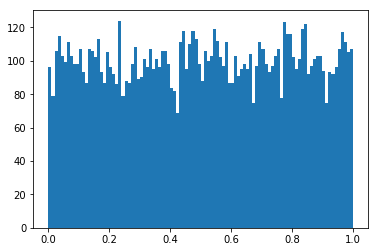

In [ ]:
beta = torch.distributions.beta.Beta(torch.tensor([0.0001]), torch.tensor([0.0001]))
beta = torch.distributions.uniform.Uniform(torch.tensor([0.0]), torch.tensor([1.0]))
plt.hist(beta.sample([10000]).numpy()[:, 0], bins=100)
plt.show()

In [ ]:
def go(counter):
    widths = [30] * 10
    base = CPPNNet(widths, output_channels=widths[-1], input_channels=4)
    viz = UpsampleNet(base, reps=1).to(device)

    c = 1.0
    skip = 5
    FEATURE_CHANNEL = 32
    # FEATURE_CHANNEL = 43
    def imgnet_objective(output, alpha):
        r = model((output - mean) / std)
    #     return torch.mean((r - targ) ** 2
    #     alpha, beta = alpha
    #     loss = (alpha * -r[:, FEATURE_CHANNEL]).mean() + ((1 - alpha) * -r[:, FEATURE_CHANNEL + 2]).mean()
    #     loss += (beta * -r[:, FEATURE_CHANNEL + 6]).mean() + ((1 - beta) * -r[:, FEATURE_CHANNEL + 5]).mean()

        sel = torch.LongTensor([FEATURE_CHANNEL + i for i in range(0, 4 * skip, skip)])
        loss = -r[:, sel] * ((alpha.unsqueeze(2) * (1-alpha).unsqueeze(1)).view(alpha.shape[0], -1))
        loss = loss.mean()

    #     loss = -r[:, FEATURE_CHANNEL].mean()
        return loss

    size = [59, 105]
    xy = get_xy_mesh(size).to(device)
    def im_gen_fn(pct_done=0.0, num=16):
        xy_crop = []
        for i in range(num):
            x0 = np.random.randint(0, 105 - 59)
            xy_crop.append(xy[:, :, :, x0:x0 + 59])
        xy_crop = torch.cat(xy_crop, 0)
        r = beta.sample([xy_crop.shape[0], 2])[..., -1].to(device)
        alpha = r.round()  # 16, 2
        other = r * c * 2.0 - 1.0 * c
        other = other.view(xy_crop.shape[0], 2, 1, 1).repeat([1, 1, xy_crop.shape[2], xy_crop.shape[3]])
        xy_crop = torch.cat([xy_crop, other], 1)
        return viz(xy_crop), alpha

    opt = optim.Adam(viz.parameters(), lr=0.002)
    div = 5

    train_visualiser(imgnet_objective, im_gen_fn, opt, iters=30*50//div, log_interval=50//div)

    torch.save(viz.state_dict(), '/home/liam/dreamz/data/state_dicts/%04d.pth' % counter)

In [ ]:
for counter in range(75, 500):
    go(counter)

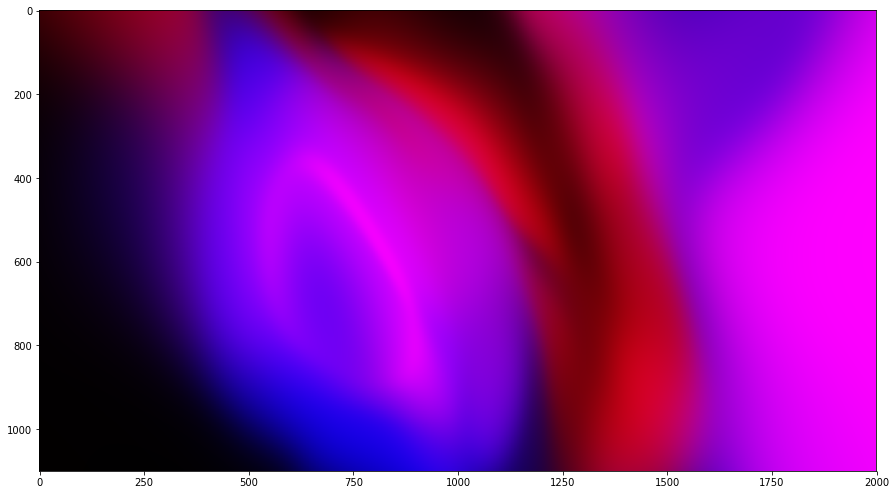

In [11]:
xy_big = get_xy_mesh([277, 502]).to(device)
other = torch.ones([xy_big.shape[0], 2]).to(device) * 2.0 * c - 1.0 * c
other = other.view(xy_big.shape[0], 2, 1, 1).repeat([1, 1, xy_big.shape[2], xy_big.shape[3]])
xy_big = torch.cat([xy_big, other], 1)
res = viz(xy_big)
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

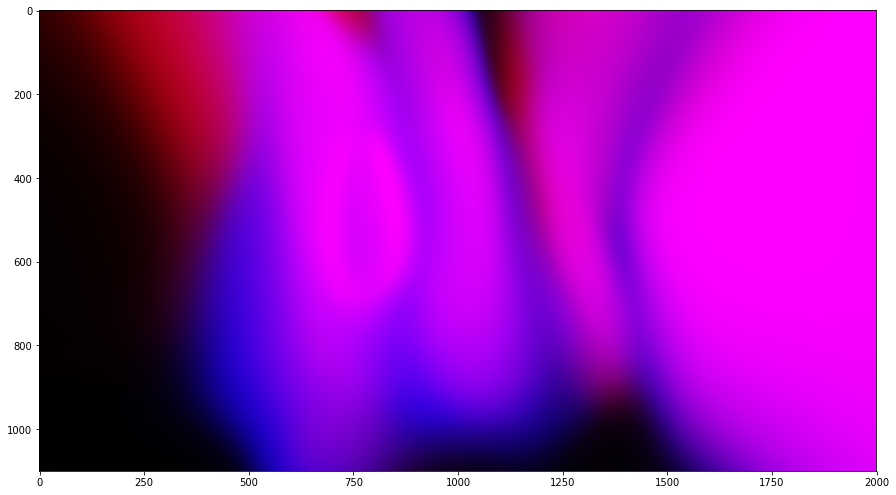

In [12]:
xy_big = get_xy_mesh([277, 502]).to(device)
other = torch.zeros([xy_big.shape[0], 2]).to(device) * 2.0 * c - 1.0 * c
other = other.view(xy_big.shape[0], 2, 1, 1).repeat([1, 1, xy_big.shape[2], xy_big.shape[3]])
xy_big = torch.cat([xy_big, other], 1)
res = viz(xy_big)
from dreamz.utils import display_tch_im
plt.figure(figsize=[15]*2)
display_tch_im(res)

In [13]:
class Wrapper(nn.Module):
    def __init__(self, m):
        super(Wrapper, self).__init__()
        self.m = m

    def forward(self, x, o):
        o = o.view([1, 2, 1, 1])
        o = o.repeat([x.size(0), 1, x.size(2), x.size(3)])
        x = torch.cat([x, o], 1)
        x = self.m(x)
        x = torch.cat([x, torch.ones([x.size(0), 1, x.size(2), x.size(3)]).to(x.device)], 1)
        return x.permute(0, 3, 2, 1)

x, o = get_xy_mesh([200, 200]), torch.FloatTensor([0.3, 0.4])
[x, o] = [i.to(device) for i in [x, o]]
cppn_trace = torch.jit.trace(Wrapper(viz), (x, o))
torch.jit.save(cppn_trace, '/home/liam/cppns/{}.pth'.format)

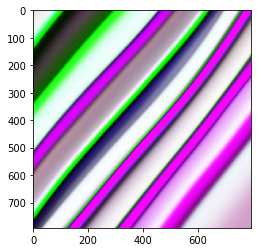

In [14]:
x, o = get_xy_mesh([200, 200]), torch.FloatTensor([-0.3, 0.4])
[x, o] = [i.to(device) for i in [x, o]]
outp = cppn_trace(x, o).to(device)
plt.imshow(outp.detach().cpu().numpy()[0])
plt.show()